Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68118
[1]	validation_0-logloss:0.67017
[2]	validation_0-logloss:0.66012
[3]	validation_0-logloss:0.65087
[4]	validation_0-logloss:0.64259
[5]	validation_0-logloss:0.63430
[6]	validation_0-logloss:0.62680
[7]	validation_0-logloss:0.61990
[8]	validation_0-logloss:0.61353
[9]	validation_0-logloss:0.60751
[10]	validation_0-logloss:0.60231
[11]	validation_0-logloss:0.59741
[12]	validation_0-logloss:0.59298
[13]	validation_0-logloss:0.58898
[14]	validation_0-logloss:0.58510
[15]	validation_0-logloss:0.58112
[16]	validation_0-logloss:0.57773
[17]	validation_0-logloss:0.57454
[18]	validation_0-logloss:0.57156
[19]	validation_0-logloss:0.56842
[20]	validation_0-logloss:0.56575
[21]	validation_0-logloss:0.56300
[22]	validation_0-logloss:0.56068
[23]	validation_0-logloss:0.55848
[24]	validation_0-logloss:0.55668
[25]	validation_0-logloss:0.55475
[26]	validation_0-logloss:0.55284
[27]	validation_0-logloss:0.55121
[28]	validation_0-logloss:0.54955
[29]	validation_0-loglos

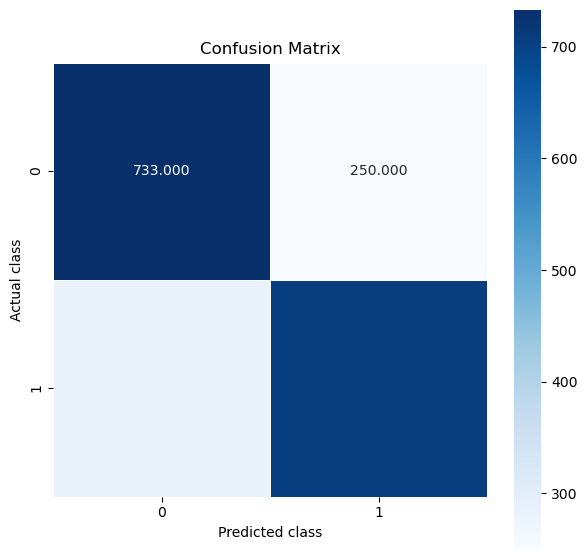

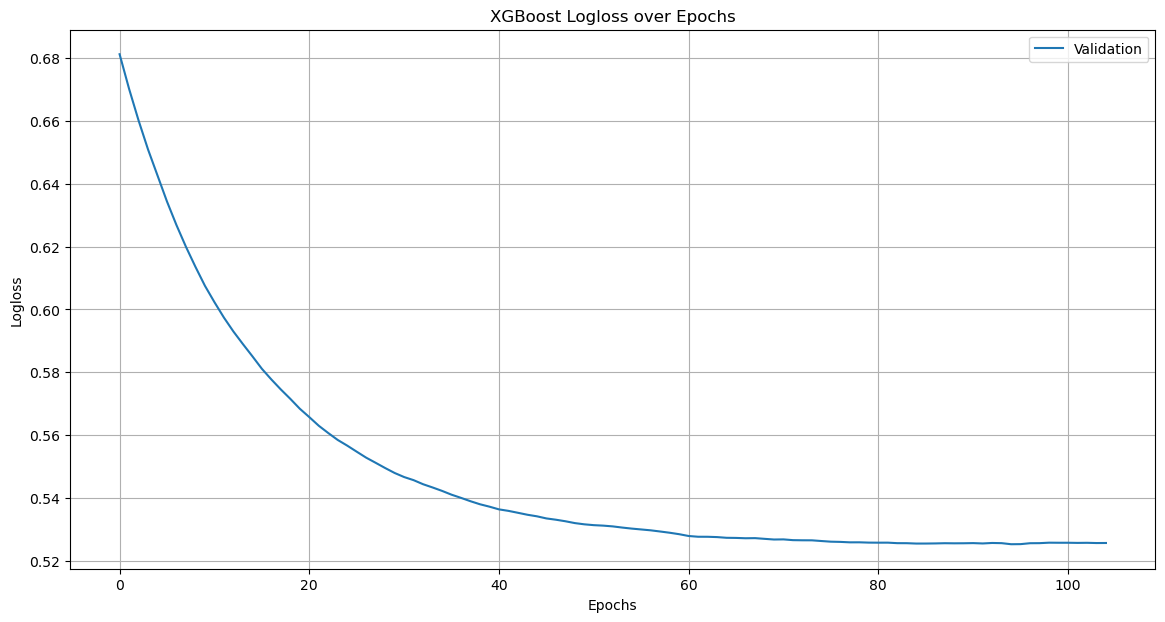

In [4]:
# 기본 모델

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint

# 데이터 불러오기
df = pd.read_csv('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min.csv')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 300),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_lambda': uniform(1, 10),
    'reg_alpha': uniform(0, 5)
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Randomized Search 초기화
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,   # 샘플링할 수의 수
    cv=3,         # 3겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    random_state=42,
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
random_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)], verbose=True)
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {random_search.best_params_}')

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68118
[1]	validation_0-logloss:0.67017
[2]	validation_0-logloss:0.66012
[3]	validation_0-logloss:0.65087
[4]	validation_0-logloss:0.64259
[5]	validation_0-logloss:0.63430
[6]	validation_0-logloss:0.62680
[7]	validation_0-logloss:0.61990
[8]	validation_0-logloss:0.61353
[9]	validation_0-logloss:0.60751
[10]	validation_0-logloss:0.60231
[11]	validation_0-logloss:0.59741
[12]	validation_0-logloss:0.59298
[13]	validation_0-logloss:0.58898
[14]	validation_0-logloss:0.58510
[15]	validation_0-logloss:0.58112
[16]	validation_0-logloss:0.57773
[17]	validation_0-logloss:0.57454
[18]	validation_0-logloss:0.57156
[19]	validation_0-logloss:0.56842
[20]	validation_0-logloss:0.56575
[21]	validation_0-logloss:0.56300
[22]	validation_0-logloss:0.56068
[23]	validation_0-logloss:0.55848
[24]	validation_0-logloss:0.55668
[25]	validation_0-logloss:0.55475
[26]	validation_0-logloss:0.55284
[27]	validation_0-logloss:0.55121
[28]	validation_0-logloss:0.54955
[29]	validation_0-loglos

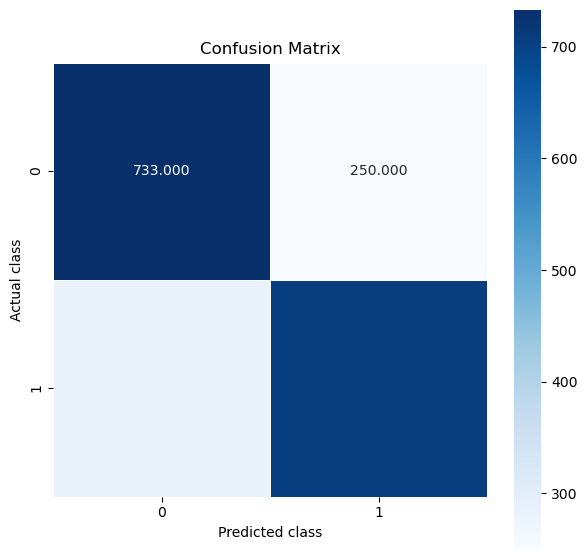

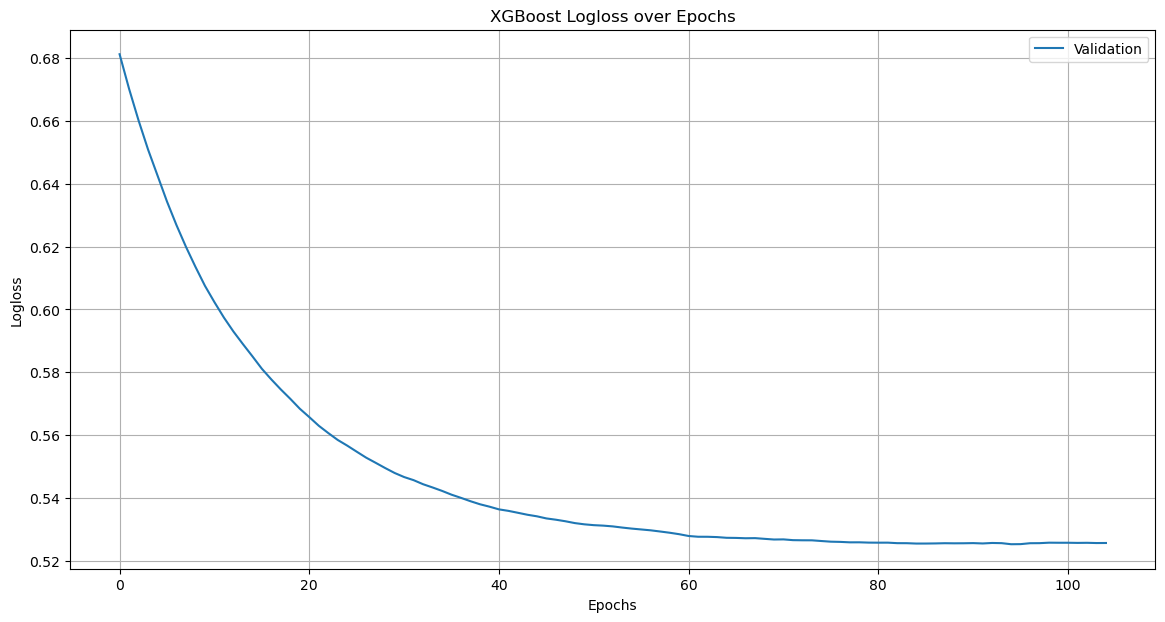

In [5]:
# 에폭만 증가

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint

# 데이터 불러오기
df = pd.read_csv('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min.csv')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'n_estimators': randint(300, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_lambda': uniform(1, 10),
    'reg_alpha': uniform(0, 5)
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Randomized Search 초기화
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,   # 샘플링할 수의 수
    cv=3,         # 3겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    random_state=42,
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
random_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)], verbose=True)   # early_stopping_rounds=10 성능이 지정한 구간동안 향상되지 않으면 멈춘다
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {random_search.best_params_}')

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.67929
[1]	validation_0-logloss:0.66677
[2]	validation_0-logloss:0.65540
[3]	validation_0-logloss:0.64510
[4]	validation_0-logloss:0.63621
[5]	validation_0-logloss:0.62760
[6]	validation_0-logloss:0.61968
[7]	validation_0-logloss:0.61222
[8]	validation_0-logloss:0.60579
[9]	validation_0-logloss:0.59962
[10]	validation_0-logloss:0.59424
[11]	validation_0-logloss:0.58911
[12]	validation_0-logloss:0.58439
[13]	validation_0-logloss:0.58059
[14]	validation_0-logloss:0.57669
[15]	validation_0-logloss:0.57288
[16]	validation_0-logloss:0.56936
[17]	validation_0-logloss:0.56617
[18]	validation_0-logloss:0.56316
[19]	validation_0-logloss:0.56008
[20]	validation_0-logloss:0.55744
[21]	validation_0-logloss:0.55497
[22]	validation_0-logloss:0.55273
[23]	validation_0-logloss:0.55082
[24]	validation_0-logloss:0.54915
[25]	validation_0-logloss:0.54752
[26]	validation_0-logloss:0.54593
[27]	validation_0-logloss:0.54457
[28]	validation_0-logloss:0.54313
[29]	validation_0-loglos

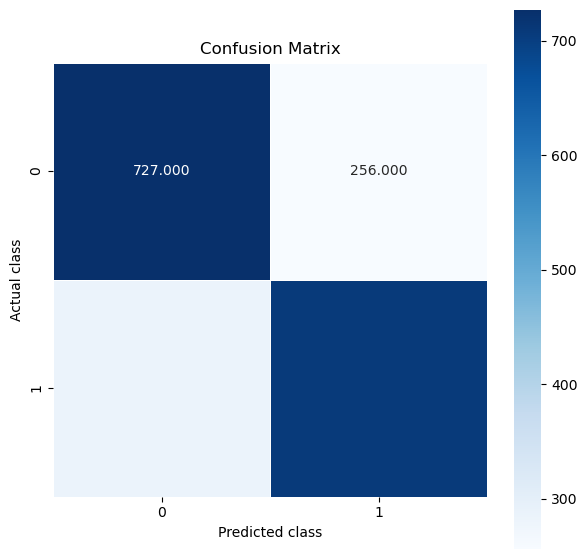

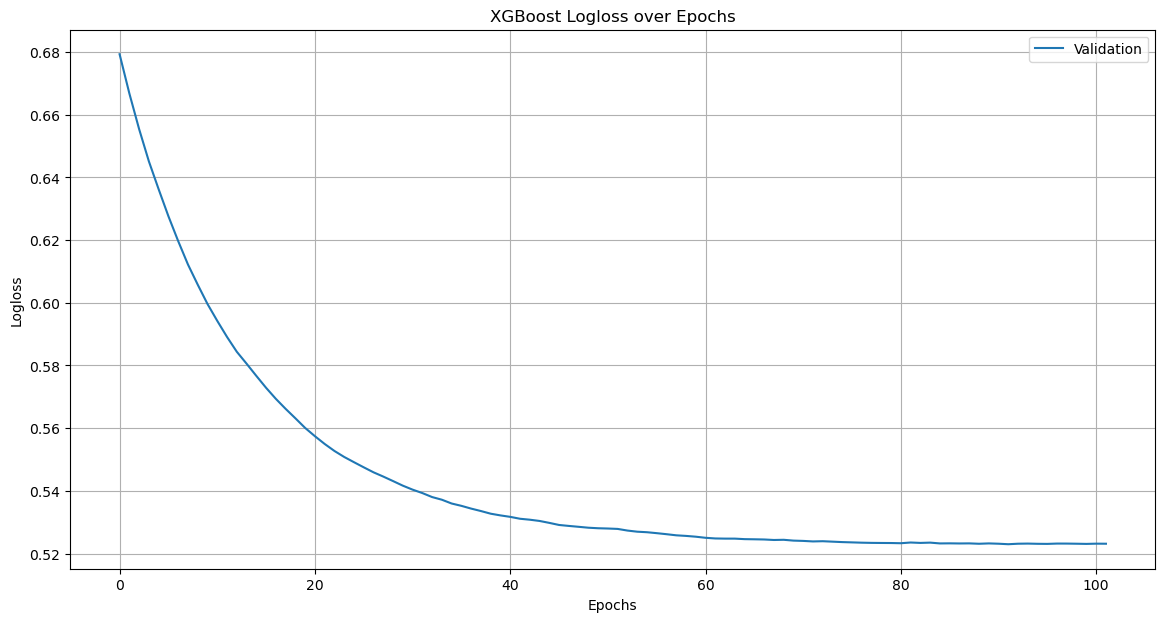

In [6]:
# 에폭을 늘려 더 많이 학습하도록 설정 -> 'n_estimators': randint(300, 500)
# 학습률을 낮추어 더 안정적이게 변경 -> 'learning_rate': uniform(0.001, 0.1)

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint

# 데이터 불러오기
df = pd.read_csv('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min.csv')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'learning_rate': uniform(0.001, 0.1),
    'max_depth': randint(3, 10),
    'n_estimators': randint(300, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_lambda': uniform(1, 10),
    'reg_alpha': uniform(0, 5)
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Randomized Search 초기화
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,   # 샘플링할 수의 수
    cv=3,         # 3겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    random_state=42,
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
random_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)], verbose=True)   # early_stopping_rounds=10 성능이 지정한 구간동안 향상되지 않으면 멈춘다
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {random_search.best_params_}')

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.67929
[1]	validation_0-logloss:0.66677
[2]	validation_0-logloss:0.65540
[3]	validation_0-logloss:0.64510
[4]	validation_0-logloss:0.63621
[5]	validation_0-logloss:0.62760
[6]	validation_0-logloss:0.61968
[7]	validation_0-logloss:0.61222
[8]	validation_0-logloss:0.60579
[9]	validation_0-logloss:0.59962
[10]	validation_0-logloss:0.59424
[11]	validation_0-logloss:0.58911
[12]	validation_0-logloss:0.58439
[13]	validation_0-logloss:0.58059
[14]	validation_0-logloss:0.57669
[15]	validation_0-logloss:0.57288
[16]	validation_0-logloss:0.56936
[17]	validation_0-logloss:0.56617
[18]	validation_0-logloss:0.56316
[19]	validation_0-logloss:0.56008
[20]	validation_0-logloss:0.55744
[21]	validation_0-logloss:0.55497
[22]	validation_0-logloss:0.55273
[23]	validation_0-logloss:0.55082
[24]	validation_0-logloss:0.54915
[25]	validation_0-logloss:0.54752
[26]	validation_0-logloss:0.54593
[27]	validation_0-logloss:0.54457
[28]	validation_0-logloss:0.54313
[29]	validation_0-loglos

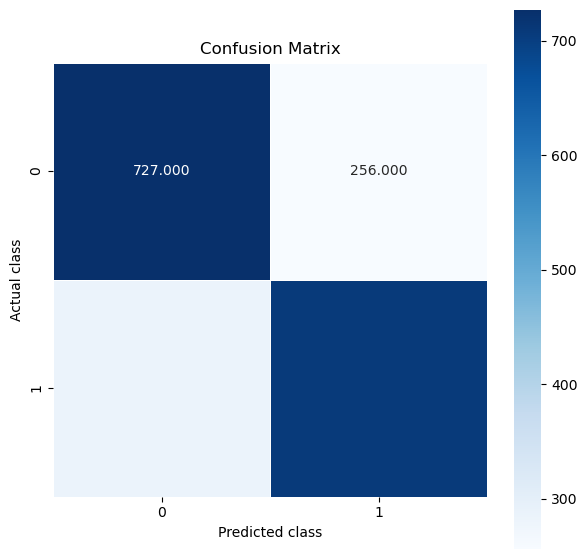

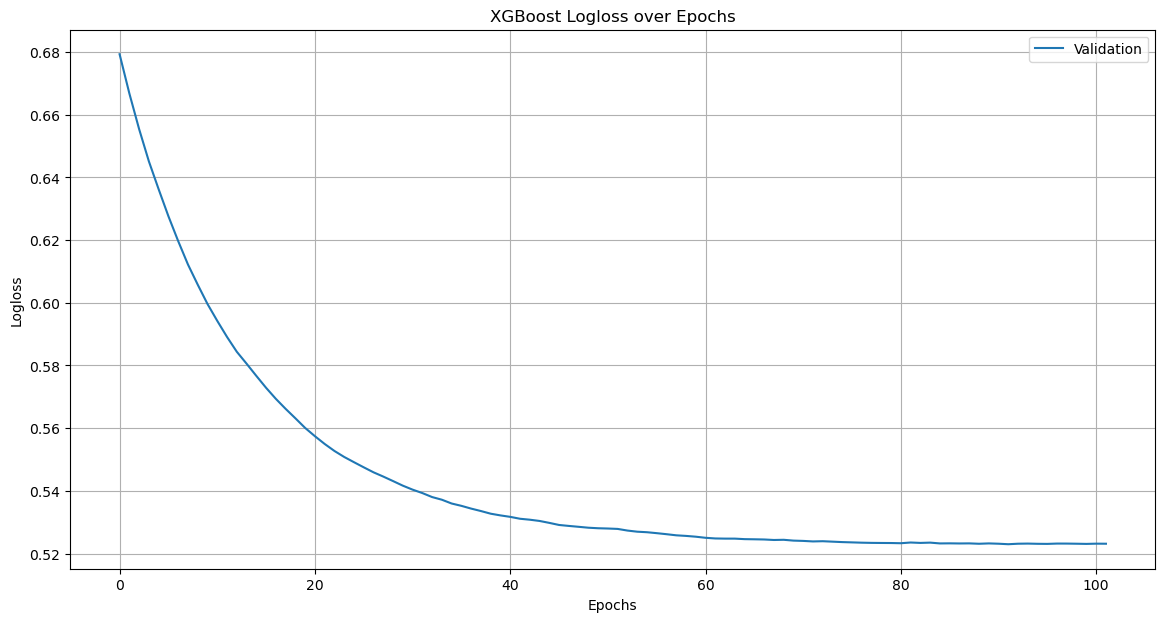

In [7]:
# 샘플링 수 증가 n_iter=200
# 교차 검증 갯수 증가 (3겹 -> 5겹)
# Fitting 5 folds for each of 200 candidates, totalling 1000 fits -> 5겹을 사용 하여 200개의 후보군을 가지고 1000개의 모델 학습

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint

# 데이터 불러오기
df = pd.read_csv('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min.csv')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'learning_rate': uniform(0.001, 0.1),
    'max_depth': randint(3, 10),
    'n_estimators': randint(300, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_lambda': uniform(1, 10),
    'reg_alpha': uniform(0, 5)
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Randomized Search 초기화
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=200,   # 샘플링할 수의 수
    cv=5,         # 3겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    random_state=42,
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
random_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)], verbose=True)   # early_stopping_rounds=10 성능이 지정한 구간동안 향상되지 않으면 멈춘다
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {random_search.best_params_}')

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.67959
[1]	validation_0-logloss:0.66722
[2]	validation_0-logloss:0.65619
[3]	validation_0-logloss:0.64596
[4]	validation_0-logloss:0.63707
[5]	validation_0-logloss:0.62831
[6]	validation_0-logloss:0.62040
[7]	validation_0-logloss:0.61313
[8]	validation_0-logloss:0.60653
[9]	validation_0-logloss:0.60043
[10]	validation_0-logloss:0.59493
[11]	validation_0-logloss:0.58998
[12]	validation_0-logloss:0.58562
[13]	validation_0-logloss:0.58172
[14]	validation_0-logloss:0.57789
[15]	validation_0-logloss:0.57415
[16]	validation_0-logloss:0.57095
[17]	validation_0-logloss:0.56783
[18]	validation_0-logloss:0.56493
[19]	validation_0-logloss:0.56180
[20]	validation_0-logloss:0.55912
[21]	validation_0-logloss:0.55662
[22]	validation_0-logloss:0.55443
[23]	validation_0-logloss:0.55257
[24]	validation_0-logloss:0.55111
[25]	validation_0-logloss:0.54927
[26]	validation_0-logloss:0.54771
[27]	validation_0-logloss:0.54639
[28]	validation_0-logloss:0.54491
[29]	validation_0-loglos

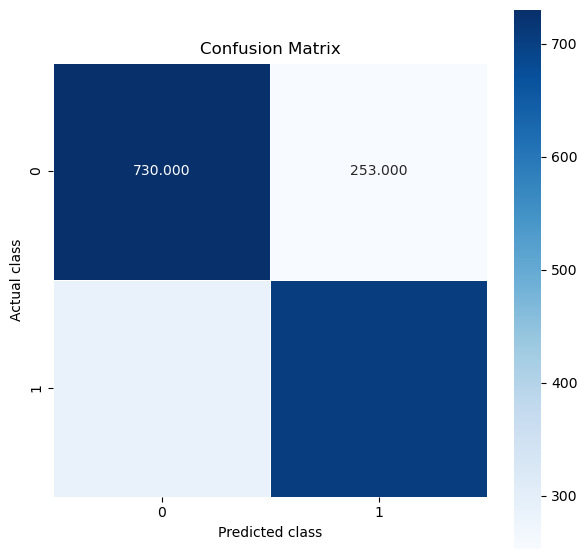

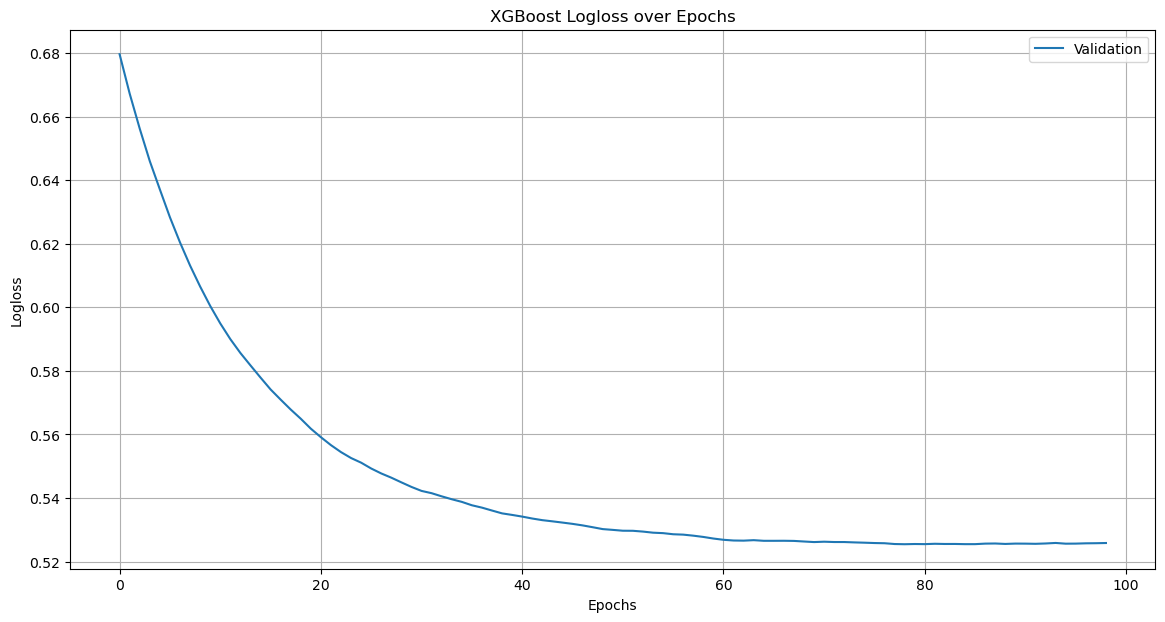

In [8]:
# 샘플링 수 증가 n_iter=200
# 교차 검증 갯수 증가 (3겹 -> 5겹)
# Fitting 5 folds for each of 200 candidates, totalling 1000 fits -> 5겹을 사용 하여 200개의 후보군을 가지고 1000개의 모델 학습
# 성능 향상 시간 20으로 증가 -> 조기 종료 기준 20 -> 향샹도가 낮을 경우 종류

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint

# 데이터 불러오기
df = pd.read_csv('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min.csv')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'learning_rate': uniform(0.001, 0.1),
    'max_depth': randint(3, 10),
    'n_estimators': randint(300, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_lambda': uniform(1, 10),
    'reg_alpha': uniform(0, 5)
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Randomized Search 초기화
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=200,   # 샘플링할 수의 수
    cv=5,         # 3겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    random_state=42,
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
random_search.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_valid, y_valid)], verbose=True)   # early_stopping_rounds=10 성능이 지정한 구간동안 향상되지 않으면 멈춘다
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {random_search.best_params_}')

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68513
[1]	validation_0-logloss:0.67740
[2]	validation_0-logloss:0.67019
[3]	validation_0-logloss:0.66346
[4]	validation_0-logloss:0.65705
[5]	validation_0-logloss:0.65097
[6]	validation_0-logloss:0.64509
[7]	validation_0-logloss:0.63973
[8]	validation_0-logloss:0.63455
[9]	validation_0-logloss:0.62963
[10]	validation_0-logloss:0.62489
[11]	validation_0-logloss:0.62063
[12]	validation_0-logloss:0.61646
[13]	validation_0-logloss:0.61257
[14]	validation_0-logloss:0.60886
[15]	validation_0-logloss:0.60528
[16]	validation_0-logloss:0.60182
[17]	validation_0-logloss:0.59866
[18]	validation_0-logloss:0.59568
[19]	validation_0-logloss:0.59256
[20]	validation_0-logloss:0.58955
[21]	validation_0-logloss:0.58680
[22]	validation_0-logloss:0.58414
[23]	validation_0-logloss:0.58173
[24]	validation_0-logloss:0.57949
[25]	validation_0-logloss:0.57732
[26]	validation_0-logloss:0.57523
[27]	validation_0-logloss:0.57326
[28]	validation_0-logloss:0.57130
[29]	validation_0-loglos

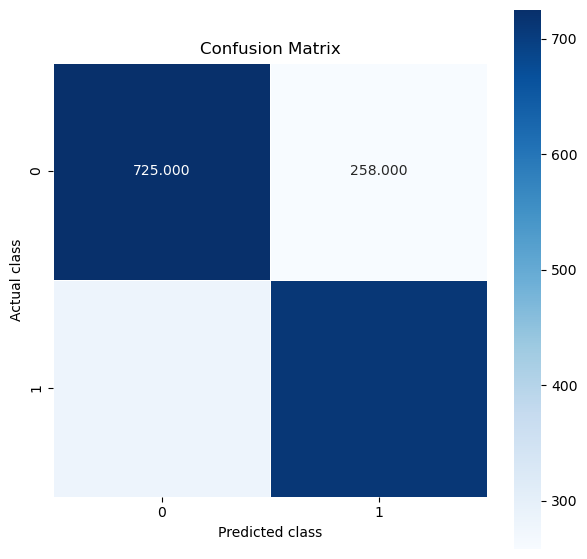

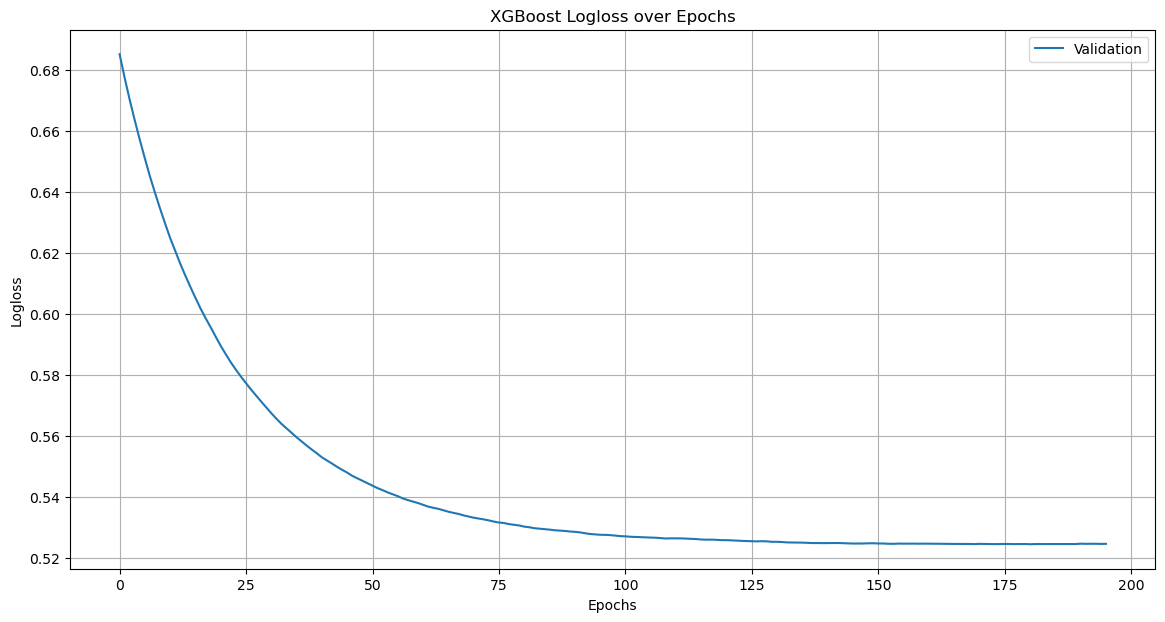

In [9]:
# 샘플링 수 증가 n_iter=200
# 교차 검증 갯수 증가 (3겹 -> 5겹)
# Fitting 5 folds for each of 200 candidates, totalling 1000 fits -> 5겹을 사용 하여 200개의 후보군을 가지고 1000개의 모델 학습
# 성능 향상 시간 20으로 증가 -> 조기 종료 기준 20 -> 향샹도가 낮을 경우 종류
# 조기 종료 기준 15로 조정

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint

# 데이터 불러오기
df = pd.read_csv('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min.csv')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'learning_rate': uniform(0.001, 0.1),
    'max_depth': randint(3, 10),
    'n_estimators': randint(300, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_lambda': uniform(1, 10),
    'reg_alpha': uniform(0, 5)
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Randomized Search 초기화
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=200,   # 샘플링할 수의 수
    cv=5,         # 5겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    random_state=42,
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
random_search.fit(X_train, y_train, early_stopping_rounds=15, eval_set=[(X_valid, y_valid)], verbose=True)   # early_stopping_rounds=10 성능이 지정한 구간동안 향상되지 않으면 멈춘다
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {random_search.best_params_}')

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68513
[1]	validation_0-logloss:0.67740
[2]	validation_0-logloss:0.67019
[3]	validation_0-logloss:0.66346
[4]	validation_0-logloss:0.65705
[5]	validation_0-logloss:0.65097
[6]	validation_0-logloss:0.64509
[7]	validation_0-logloss:0.63973
[8]	validation_0-logloss:0.63455
[9]	validation_0-logloss:0.62963
[10]	validation_0-logloss:0.62489
[11]	validation_0-logloss:0.62063
[12]	validation_0-logloss:0.61646
[13]	validation_0-logloss:0.61257
[14]	validation_0-logloss:0.60886
[15]	validation_0-logloss:0.60528
[16]	validation_0-logloss:0.60182
[17]	validation_0-logloss:0.59866
[18]	validation_0-logloss:0.59568
[19]	validation_0-logloss:0.59256
[20]	validation_0-logloss:0.58955
[21]	validation_0-logloss:0.58680
[22]	validation_0-logloss:0.58414
[23]	validation_0-logloss:0.58173
[24]	validation_0-logloss:0.57949
[25]	validation_0-logloss:0.57732
[26]	validation_0-logloss:0.57523
[27]	validation_0-logloss:0.57326
[28]	validation_0-logloss:0.57130
[29]	validation_0-loglos

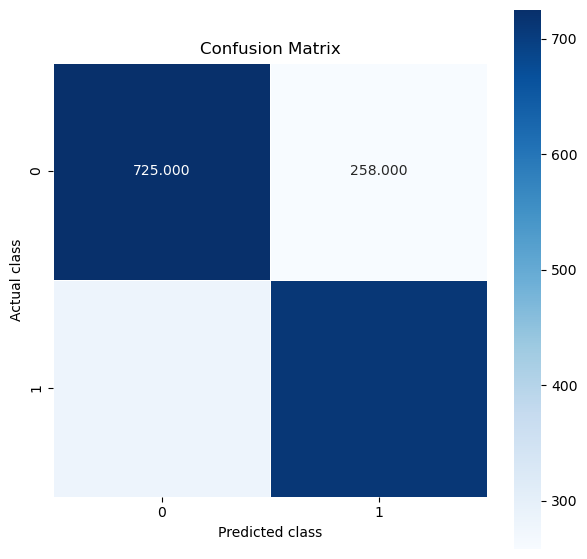

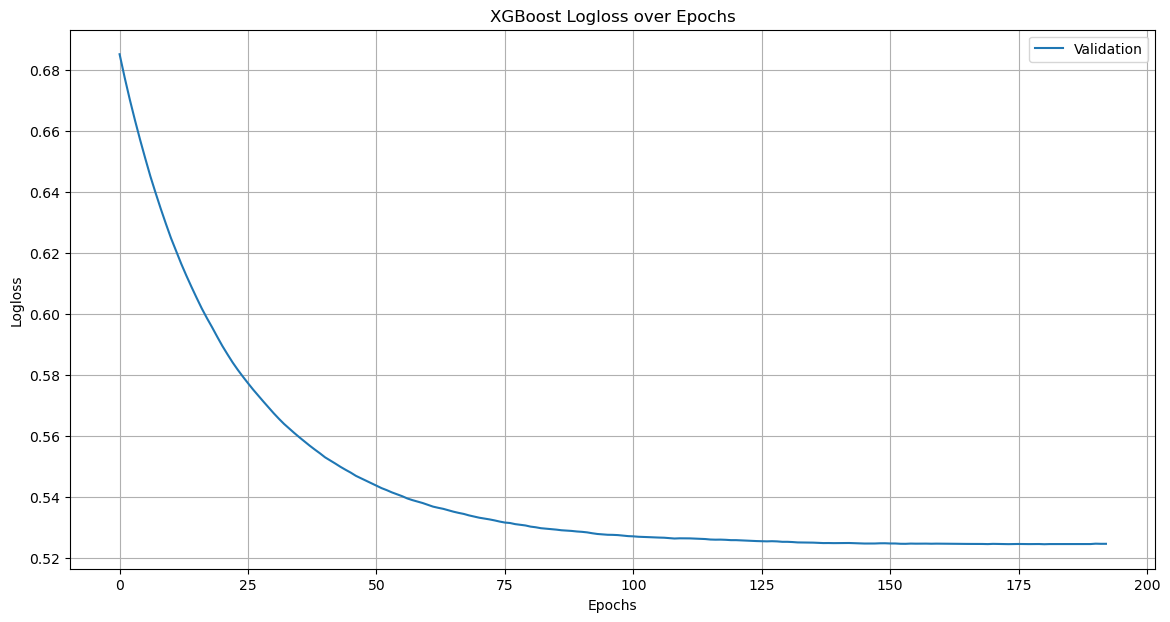

In [10]:
# 샘플링 수 증가 n_iter=200
# 교차 검증 갯수 증가 (3겹 -> 5겹)
# Fitting 5 folds for each of 200 candidates, totalling 1000 fits -> 5겹을 사용 하여 200개의 후보군을 가지고 1000개의 모델 학습
# 성능 향상 시간 20으로 증가 -> 조기 종료 기준 20 -> 향샹도가 낮을 경우 종류
# 조기 종료 기준 12로 조정

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint

# 데이터 불러오기
df = pd.read_csv('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min.csv')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'learning_rate': uniform(0.001, 0.1),
    'max_depth': randint(3, 10),
    'n_estimators': randint(300, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_lambda': uniform(1, 10),
    'reg_alpha': uniform(0, 5)
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Randomized Search 초기화
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=200,   # 샘플링할 수의 수
    cv=5,         # 5겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    random_state=42,
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
random_search.fit(X_train, y_train, early_stopping_rounds=12, eval_set=[(X_valid, y_valid)], verbose=True)   # early_stopping_rounds=10 성능이 지정한 구간동안 향상되지 않으면 멈춘다
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {random_search.best_params_}')

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[0]	validation_0-logloss:0.67959
[1]	validation_0-logloss:0.66722
[2]	validation_0-logloss:0.65619
[3]	validation_0-logloss:0.64596
[4]	validation_0-logloss:0.63707
[5]	validation_0-logloss:0.62831
[6]	validation_0-logloss:0.62040
[7]	validation_0-logloss:0.61313
[8]	validation_0-logloss:0.60653
[9]	validation_0-logloss:0.60043
[10]	validation_0-logloss:0.59493
[11]	validation_0-logloss:0.58998
[12]	validation_0-logloss:0.58562
[13]	validation_0-logloss:0.58172
[14]	validation_0-logloss:0.57789
[15]	validation_0-logloss:0.57415
[16]	validation_0-logloss:0.57095
[17]	validation_0-logloss:0.56783
[18]	validation_0-logloss:0.56493
[19]	validation_0-logloss:0.56180
[20]	validation_0-logloss:0.55912
[21]	validation_0-logloss:0.55662
[22]	validation_0-logloss:0.55443
[23]	validation_0-logloss:0.55257
[24]	validation_0-logloss:0.55111
[25]	validation_0-logloss:0.54927
[26]	validation_0-logloss:0.54771
[27]	validation_0-logloss:0.

c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-logloss:0.53878
[35]	validation_0-logloss:0.53771
[36]	validation_0-logloss:0.53697
[37]	validation_0-logloss:0.53606
[38]	validation_0-logloss:0.53516
[39]	validation_0-logloss:0.53467
[40]	validation_0-logloss:0.53415
[41]	validation_0-logloss:0.53354
[42]	validation_0-logloss:0.53303
[43]	validation_0-logloss:0.53266
[44]	validation_0-logloss:0.53227
[45]	validation_0-logloss:0.53186
[46]	validation_0-logloss:0.53138
[47]	validation_0-logloss:0.53081
[48]	validation_0-logloss:0.53022
[49]	validation_0-logloss:0.52997
[50]	validation_0-logloss:0.52970
[51]	validation_0-logloss:0.52968
[52]	validation_0-logloss:0.52943
[53]	validation_0-logloss:0.52909
[54]	validation_0-logloss:0.52894
[55]	validation_0-logloss:0.52859
[56]	validation_0-logloss:0.52847
[57]	validation_0-logloss:0.52815
[58]	validation_0-logloss:0.52775
[59]	validation_0-logloss:0.52724
[60]	validation_0-logloss:0.52685
[61]	validation_0-logloss:0.52663
[62]	validation_0-logloss:0.52658
[63]	validatio

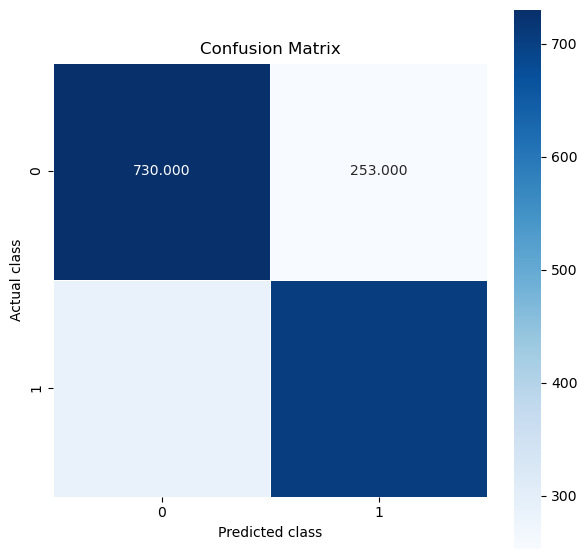

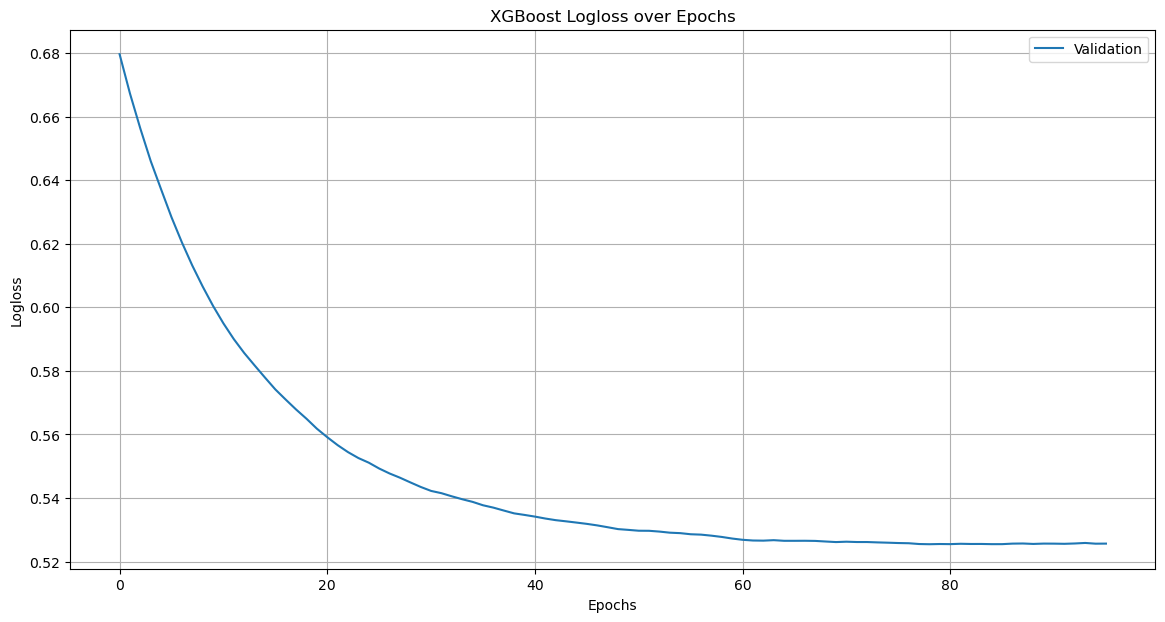

In [11]:
# 샘플링 수 증가 n_iter=200
# 교차 검증 갯수 증가 (3겹 -> 5겹)
# Fitting 5 folds for each of 200 candidates, totalling 1000 fits -> 5겹을 사용 하여 200개의 후보군을 가지고 1000개의 모델 학습
# 성능 향상 시간 20으로 증가 -> 조기 종료 기준 20 -> 향샹도가 낮을 경우 종류
# 조기 종료 기준 17로 조정

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint

# 데이터 불러오기
df = pd.read_csv('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min.csv')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'learning_rate': uniform(0.001, 0.1),
    'max_depth': randint(3, 10),
    'n_estimators': randint(300, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_lambda': uniform(1, 10),
    'reg_alpha': uniform(0, 5)
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Randomized Search 초기화
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=200,   # 샘플링할 수의 수
    cv=5,         # 5겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    random_state=42,
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
random_search.fit(X_train, y_train, early_stopping_rounds=17, eval_set=[(X_valid, y_valid)], verbose=True)   # early_stopping_rounds=10 성능이 지정한 구간동안 향상되지 않으면 멈춘다
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {random_search.best_params_}')

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[0]	validation_0-logloss:0.67959
[1]	validation_0-logloss:0.66722
[2]	validation_0-logloss:0.65619
[3]	validation_0-logloss:0.64596
[4]	validation_0-logloss:0.63707
[5]	validation_0-logloss:0.62831
[6]	validation_0-logloss:0.62040
[7]	validation_0-logloss:0.61313
[8]	validation_0-logloss:0.60653
[9]	validation_0-logloss:0.60043
[10]	validation_0-logloss:0.59493
[11]	validation_0-logloss:0.58998
[12]	validation_0-logloss:0.58562
[13]	validation_0-logloss:0.58172
[14]	validation_0-logloss:0.57789
[15]	validation_0-logloss:0.57415
[16]	validation_0-logloss:0.57095
[17]	validation_0-logloss:0.56783
[18]	validation_0-logloss:0.56493
[19]	validation_0-logloss:0.56180
[20]	validation_0-logloss:0.55912
[21]	validation_0-logloss:0.55662
[22]	validation_0-logloss:0.55443
[23]	validation_0-logloss:0.55257
[24]	validation_0-logloss:0.55111
[25]	validation_0-logloss:0.54927
[26]	validation_0-logloss:0.54771
[27]	validation_0-logloss:0.5

c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-logloss:0.53771
[36]	validation_0-logloss:0.53697
[37]	validation_0-logloss:0.53606
[38]	validation_0-logloss:0.53516
[39]	validation_0-logloss:0.53467
[40]	validation_0-logloss:0.53415
[41]	validation_0-logloss:0.53354
[42]	validation_0-logloss:0.53303
[43]	validation_0-logloss:0.53266
[44]	validation_0-logloss:0.53227
[45]	validation_0-logloss:0.53186
[46]	validation_0-logloss:0.53138
[47]	validation_0-logloss:0.53081
[48]	validation_0-logloss:0.53022
[49]	validation_0-logloss:0.52997
[50]	validation_0-logloss:0.52970
[51]	validation_0-logloss:0.52968
[52]	validation_0-logloss:0.52943
[53]	validation_0-logloss:0.52909
[54]	validation_0-logloss:0.52894
[55]	validation_0-logloss:0.52859
[56]	validation_0-logloss:0.52847
[57]	validation_0-logloss:0.52815
[58]	validation_0-logloss:0.52775
[59]	validation_0-logloss:0.52724
[60]	validation_0-logloss:0.52685
[61]	validation_0-logloss:0.52663
[62]	validation_0-logloss:0.52658
[63]	validation_0-logloss:0.52673
[64]	validatio

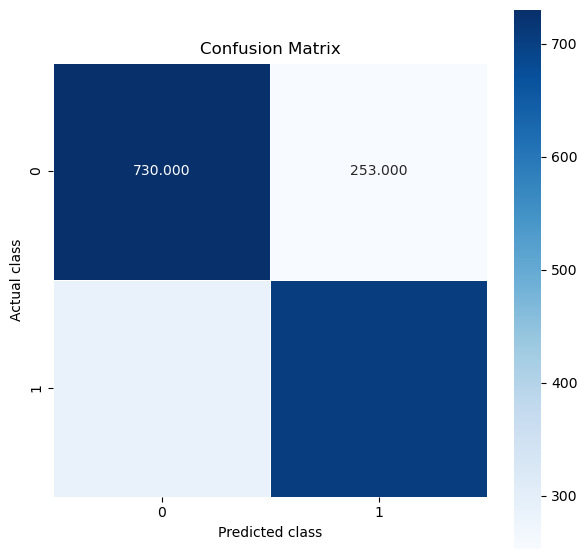

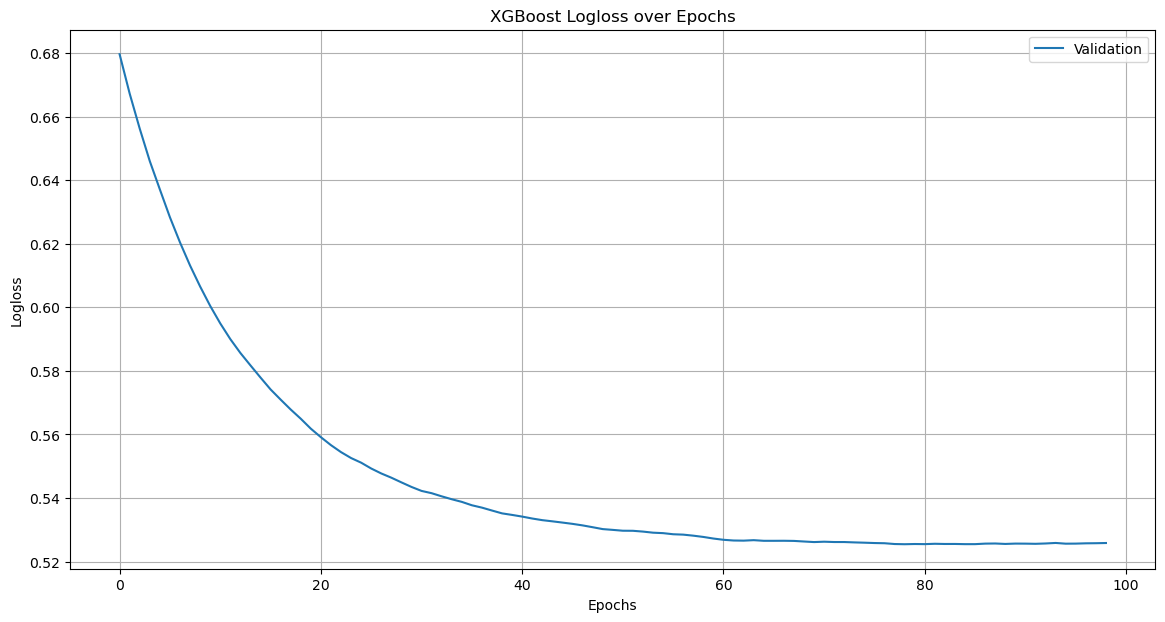

In [12]:
# 샘플링 수 증가 n_iter=200
# 교차 검증 갯수 증가 (3겹 -> 5겹)
# Fitting 5 folds for each of 200 candidates, totalling 1000 fits -> 5겹을 사용 하여 200개의 후보군을 가지고 1000개의 모델 학습
# 성능 향상 시간 20으로 증가 -> 조기 종료 기준 20 -> 향샹도가 낮을 경우 종류
# 조기 종료 기준 17로 조정

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint

# 데이터 불러오기
df = pd.read_csv('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min.csv')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'learning_rate': uniform(0.001, 0.1),
    'max_depth': randint(3, 10),
    'n_estimators': randint(300, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_lambda': uniform(1, 10),
    'reg_alpha': uniform(0, 5)
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Randomized Search 초기화
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,   # 샘플링할 수의 수
    cv=5,         # 5겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    random_state=42,
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
random_search.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_valid, y_valid)], verbose=True)   # early_stopping_rounds=10 성능이 지정한 구간동안 향상되지 않으면 멈춘다
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {random_search.best_params_}')

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[0]	validation_0-logloss:0.67567
[1]	validation_0-logloss:0.65957
[2]	validation_0-logloss:0.64617
[3]	validation_0-logloss:0.63404
[4]	validation_0-logloss:0.62350
[5]	validation_0-logloss:0.61363
[6]	validation_0-logloss:0.60534
[7]	validation_0-logloss:0.59727
[8]	validation_0-logloss:0.59015
[9]	validation_0-logloss:0.58377
[10]	validation_0-logloss:0.57836
[11]	validation_0-logloss:0.57359
[12]	validation_0-logloss:0.56894
[13]	validation_0-logloss:0.56587
[14]	validation_0-logloss:0.56231
[15]	validation_0-logloss:0.55898
[16]	validation_0-logloss:0.55630
[17]	validation_0-logloss:0.55367
[18]	validation_0-logloss:0.55140
[19]	validation_0-logloss:0.54874
[20]	validation_0-logloss:0.54659
[21]	validation_0-logloss:0.54464
[22]	validation_0-logloss:0.54292
[23]	validation_0-logloss:0.54145
[24]	validation_0-logloss:0.54024
[25]	validation_0-logloss:0.53889
[26]	validation_0-logloss:0.53774
[27]	validation_0-logloss:0.5

c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-logloss:0.53117
[35]	validation_0-logloss:0.53070
[36]	validation_0-logloss:0.53056
[37]	validation_0-logloss:0.52984
[38]	validation_0-logloss:0.52912
[39]	validation_0-logloss:0.52878
[40]	validation_0-logloss:0.52853
[41]	validation_0-logloss:0.52827
[42]	validation_0-logloss:0.52773
[43]	validation_0-logloss:0.52727
[44]	validation_0-logloss:0.52718
[45]	validation_0-logloss:0.52673
[46]	validation_0-logloss:0.52657
[47]	validation_0-logloss:0.52624
[48]	validation_0-logloss:0.52636
[49]	validation_0-logloss:0.52636
[50]	validation_0-logloss:0.52619
[51]	validation_0-logloss:0.52633
[52]	validation_0-logloss:0.52625
[53]	validation_0-logloss:0.52628
[54]	validation_0-logloss:0.52628
[55]	validation_0-logloss:0.52593
[56]	validation_0-logloss:0.52573
[57]	validation_0-logloss:0.52564
[58]	validation_0-logloss:0.52548
[59]	validation_0-logloss:0.52528
[60]	validation_0-logloss:0.52499
[61]	validation_0-logloss:0.52482
[62]	validation_0-logloss:0.52494
[63]	validatio

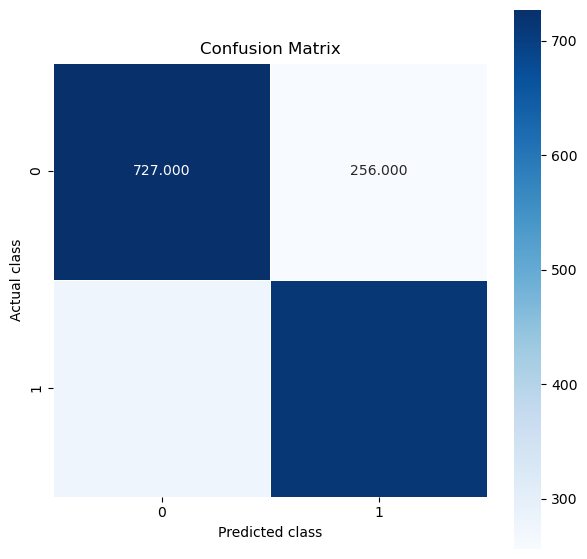

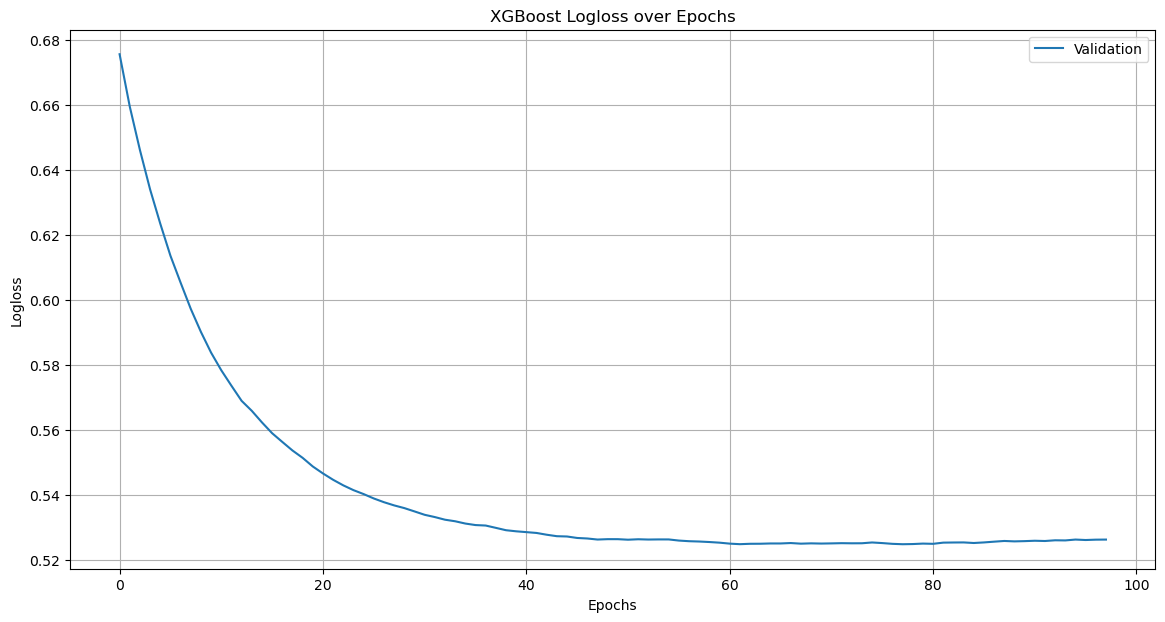

In [13]:
# 샘플링 수 증가 n_iter=200
# 교차 검증 갯수 증가 (3겹 -> 5겹)
# Fitting 5 folds for each of 200 candidates, totalling 1000 fits -> 5겹을 사용 하여 200개의 후보군을 가지고 1000개의 모델 학습
# 성능 향상 시간 20으로 증가 -> 조기 종료 기준 20 -> 향샹도가 낮을 경우 종류
# 조기 종료 기준 17로 조정

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint

# 데이터 불러오기
df = pd.read_csv('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min.csv')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 10),
    'n_estimators': randint(300, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_lambda': uniform(1, 10),
    'reg_alpha': uniform(0, 5)
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Randomized Search 초기화
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,   # 샘플링할 수의 수
    cv=5,         # 5겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    random_state=42,
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
random_search.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_valid, y_valid)], verbose=True)   # early_stopping_rounds=10 성능이 지정한 구간동안 향상되지 않으면 멈춘다
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {random_search.best_params_}')

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.67567
[1]	validation_0-logloss:0.65957
[2]	validation_0-logloss:0.64617
[3]	validation_0-logloss:0.63404
[4]	validation_0-logloss:0.62350
[5]	validation_0-logloss:0.61363
[6]	validation_0-logloss:0.60534
[7]	validation_0-logloss:0.59727
[8]	validation_0-logloss:0.59015
[9]	validation_0-logloss:0.58377
[10]	validation_0-logloss:0.57836
[11]	validation_0-logloss:0.57359
[12]	validation_0-logloss:0.56894
[13]	validation_0-logloss:0.56587
[14]	validation_0-logloss:0.56231
[15]	validation_0-logloss:0.55898
[16]	validation_0-logloss:0.55630
[17]	validation_0-logloss:0.55367
[18]	validation_0-logloss:0.55140
[19]	validation_0-logloss:0.54874
[20]	validation_0-logloss:0.54659
[21]	validation_0-logloss:0.54464
[22]	validation_0-logloss:0.54292
[23]	validation_0-logloss:0.54145
[24]	validation_0-logloss:0.54024
[25]	validation_0-logloss:0.53889
[26]	validation_0-logloss:0.53774
[27]	validation_0-logloss:0.53676
[28]	validation_0-logloss:0.53593
[29]	validation_0-loglos

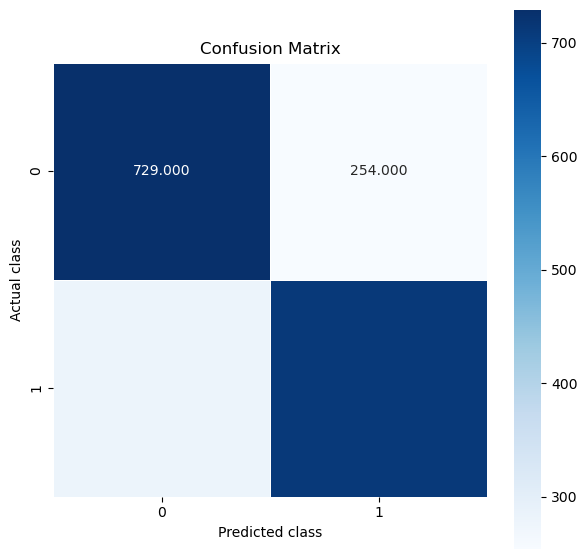

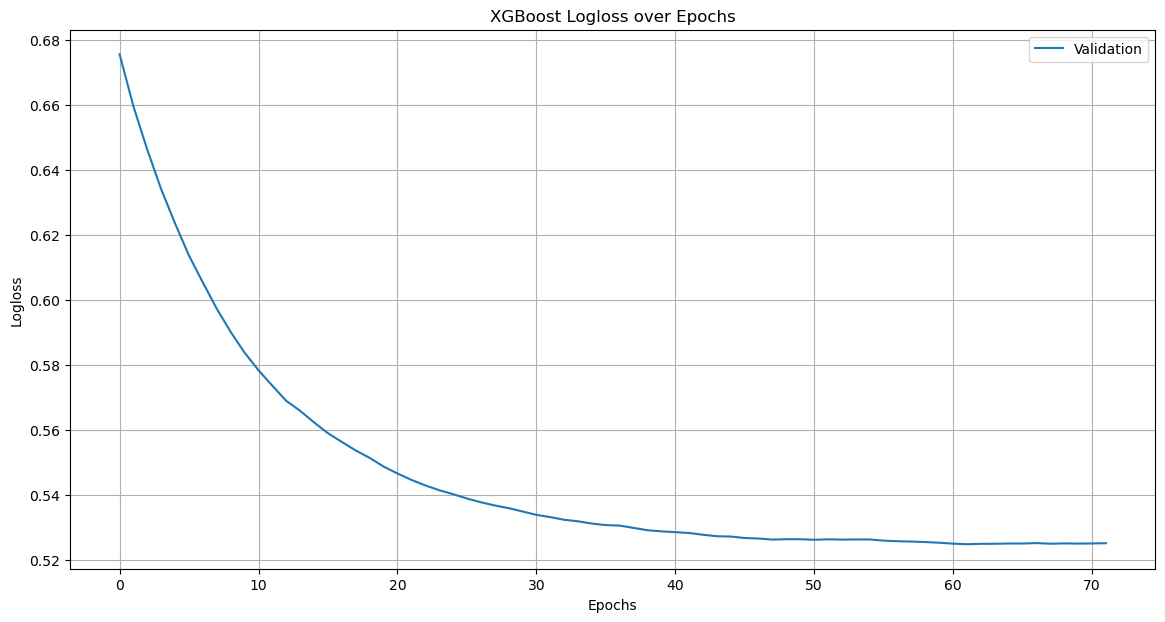

In [14]:
# 샘플링 수 증가 n_iter=200
# 교차 검증 갯수 증가 (3겹 -> 5겹)
# Fitting 5 folds for each of 200 candidates, totalling 1000 fits -> 5겹을 사용 하여 200개의 후보군을 가지고 1000개의 모델 학습
# 성능 향상 시간 20으로 증가 -> 조기 종료 기준 20 -> 향샹도가 낮을 경우 종류
# 조기 종료 기준 10로 조정

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint

# 데이터 불러오기
df = pd.read_csv('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min.csv')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 10),
    'n_estimators': randint(300, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_lambda': uniform(1, 10),
    'reg_alpha': uniform(0, 5)
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Randomized Search 초기화
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,   # 샘플링할 수의 수
    cv=5,         # 5겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    random_state=42,
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
random_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)], verbose=True)   # early_stopping_rounds=10 성능이 지정한 구간동안 향상되지 않으면 멈춘다
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {random_search.best_params_}')

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68242
[1]	validation_0-logloss:0.67248
[2]	validation_0-logloss:0.66334
[3]	validation_0-logloss:0.65484
[4]	validation_0-logloss:0.64699
[5]	validation_0-logloss:0.63974
[6]	validation_0-logloss:0.63288
[7]	validation_0-logloss:0.62640
[8]	validation_0-logloss:0.62049
[9]	validation_0-logloss:0.61494
[10]	validation_0-logloss:0.60987
[11]	validation_0-logloss:0.60489
[12]	validation_0-logloss:0.60025
[13]	validation_0-logloss:0.59573
[14]	validation_0-logloss:0.59178
[15]	validation_0-logloss:0.58791
[16]	validation_0-logloss:0.58414
[17]	validation_0-logloss:0.58067
[18]	validation_0-logloss:0.57755
[19]	validation_0-logloss:0.57471
[20]	validation_0-logloss:0.57212
[21]	validation_0-logloss:0.56967
[22]	validation_0-logloss:0.56703
[23]	validation_0-logloss:0.56461
[24]	validation_0-logloss:0.56244
[25]	validation_0-logloss:0.56031
[26]	validation_0-logloss:0.55835
[27]	validation_0-logloss:0.55638
[28]	validation_0-logloss:0.55468
[29]	validation_0-loglos

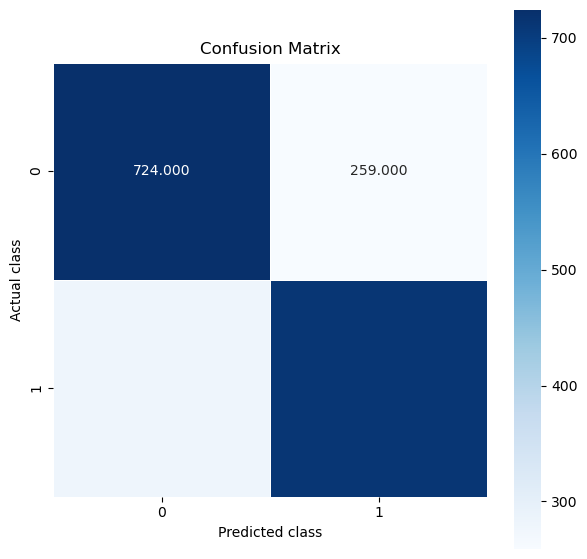

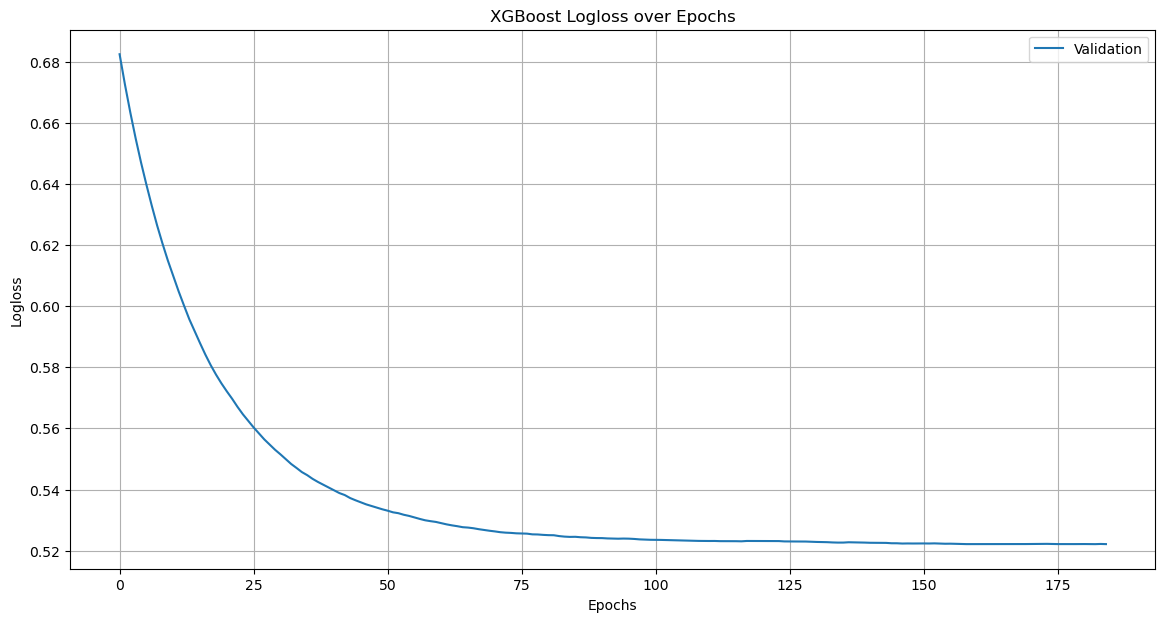

In [15]:
# 샘플링 수 증가 n_iter=200
# 교차 검증 갯수 증가 (3겹 -> 5겹)
# Fitting 5 folds for each of 200 candidates, totalling 1000 fits -> 5겹을 사용 하여 200개의 후보군을 가지고 1000개의 모델 학습
# 성능 향상 시간 20으로 증가 -> 조기 종료 기준 20 -> 향샹도가 낮을 경우 종류
# 조기 종료 기준 17로 조정
# 제일 낮게 나왔다 !!
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint

# 데이터 불러오기
df = pd.read_csv('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min.csv')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 10),
    'n_estimators': randint(300, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_lambda': uniform(1, 10),
    'reg_alpha': uniform(0, 5)
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Randomized Search 초기화
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=200,   # 샘플링할 수의 수
    cv=5,         # 5겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    random_state=42,
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
random_search.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_valid, y_valid)], verbose=True)   # early_stopping_rounds=10 성능이 지정한 구간동안 향상되지 않으면 멈춘다
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {random_search.best_params_}')

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.67959
[1]	validation_0-logloss:0.66722
[2]	validation_0-logloss:0.65619
[3]	validation_0-logloss:0.64596
[4]	validation_0-logloss:0.63707
[5]	validation_0-logloss:0.62831
[6]	validation_0-logloss:0.62040
[7]	validation_0-logloss:0.61313
[8]	validation_0-logloss:0.60653
[9]	validation_0-logloss:0.60043
[10]	validation_0-logloss:0.59493
[11]	validation_0-logloss:0.58998
[12]	validation_0-logloss:0.58562
[13]	validation_0-logloss:0.58172
[14]	validation_0-logloss:0.57789
[15]	validation_0-logloss:0.57415
[16]	validation_0-logloss:0.57095
[17]	validation_0-logloss:0.56783
[18]	validation_0-logloss:0.56493
[19]	validation_0-logloss:0.56180
[20]	validation_0-logloss:0.55912
[21]	validation_0-logloss:0.55662
[22]	validation_0-logloss:0.55443
[23]	validation_0-logloss:0.55257
[24]	validation_0-logloss:0.55111
[25]	validation_0-logloss:0.54927
[26]	validation_0-logloss:0.54771
[27]	validation_0-logloss:0.54639
[28]	validation_0-logloss:0.54491
[29]	validation_0-loglos

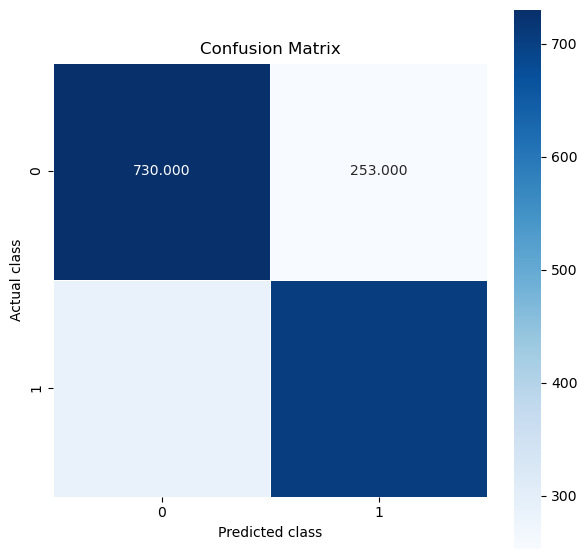

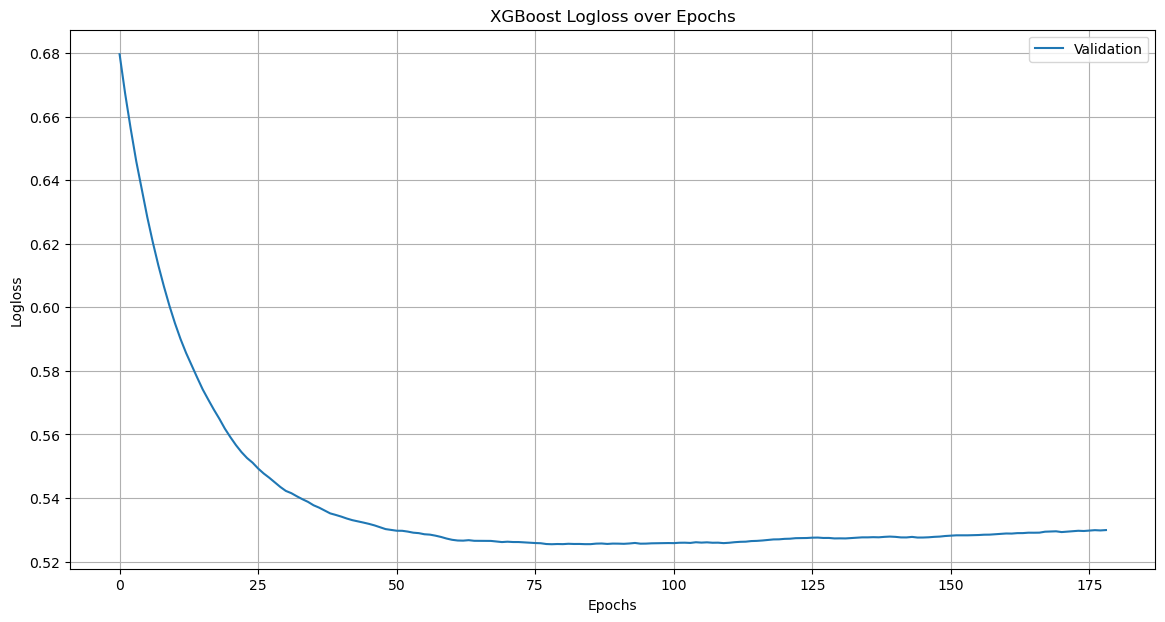

In [17]:
# 샘플링 수 증가 n_iter=200
# 교차 검증 갯수 증가 (3겹 -> 5겹)
# Fitting 5 folds for each of 200 candidates, totalling 1000 fits -> 5겹을 사용 하여 200개의 후보군을 가지고 1000개의 모델 학습
# 성능 향상 시간 20으로 증가 -> 조기 종료 기준 20 -> 향샹도가 낮을 경우 종류
# 조기 종료 기준 17로 조정

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint

# 데이터 불러오기
df = pd.read_csv('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min.csv')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'learning_rate': uniform(0.001, 0.1),
    'max_depth': randint(3, 10),
    'n_estimators': randint(300, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_lambda': uniform(1, 10),
    'reg_alpha': uniform(0, 5)
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Randomized Search 초기화
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=200,   # 샘플링할 수의 수
    cv=5,         # 5겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    random_state=42,
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
random_search.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_valid, y_valid)], verbose=True)   # early_stopping_rounds=10 성능이 지정한 구간동안 향상되지 않으면 멈춘다
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {random_search.best_params_}')

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68649
[1]	validation_0-logloss:0.68020
[2]	validation_0-logloss:0.67429
[3]	validation_0-logloss:0.66864
[4]	validation_0-logloss:0.66327
[5]	validation_0-logloss:0.65805
[6]	validation_0-logloss:0.65310
[7]	validation_0-logloss:0.64841
[8]	validation_0-logloss:0.64383
[9]	validation_0-logloss:0.63935
[10]	validation_0-logloss:0.63520
[11]	validation_0-logloss:0.63109
[12]	validation_0-logloss:0.62720
[13]	validation_0-logloss:0.62343
[14]	validation_0-logloss:0.61991
[15]	validation_0-logloss:0.61646
[16]	validation_0-logloss:0.61319
[17]	validation_0-logloss:0.60997
[18]	validation_0-logloss:0.60698
[19]	validation_0-logloss:0.60402
[20]	validation_0-logloss:0.60125
[21]	validation_0-logloss:0.59849
[22]	validation_0-logloss:0.59588
[23]	validation_0-logloss:0.59341
[24]	validation_0-logloss:0.59102
[25]	validation_0-logloss:0.58886
[26]	validation_0-logloss:0.58664
[27]	validation_0-logloss:0.58457
[28]	validation_0-logloss:0.58252
[29]	validation_0-loglos

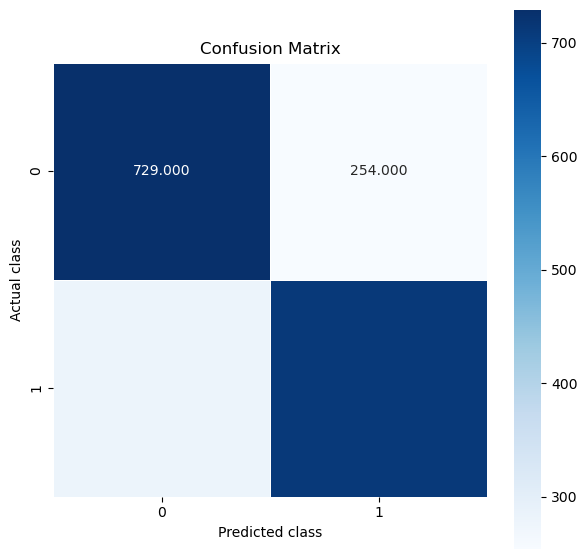

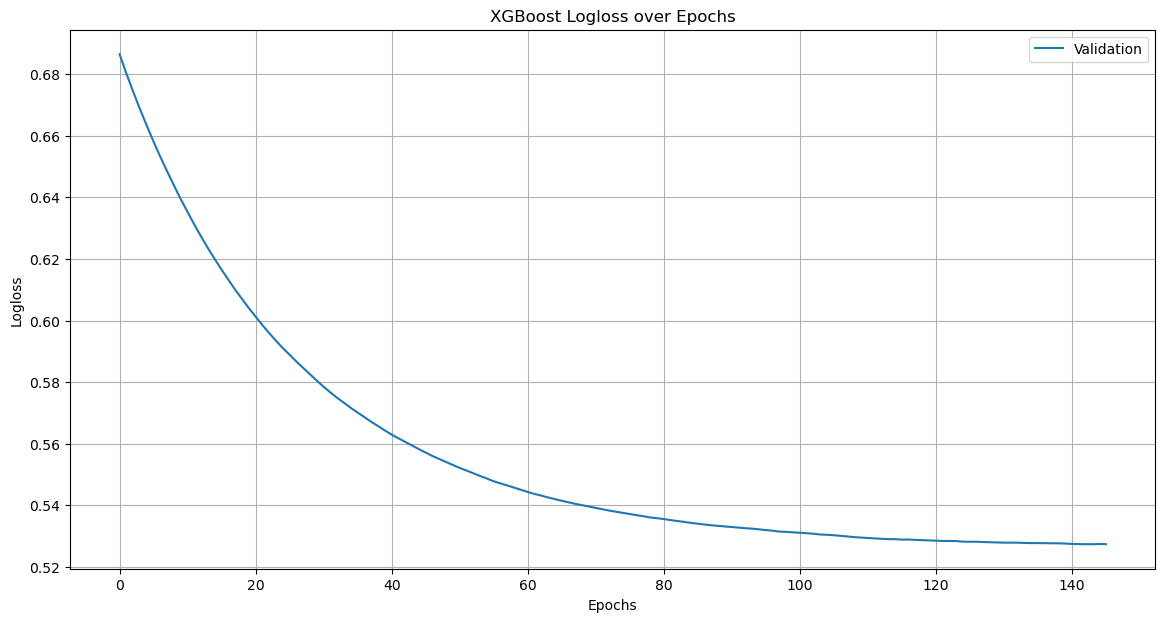

In [20]:
# 샘플링 수 증가 n_iter=200
# 교차 검증 갯수 증가 (3겹 -> 5겹)
# Fitting 5 folds for each of 200 candidates, totalling 1000 fits -> 5겹을 사용 하여 200개의 후보군을 가지고 1000개의 모델 학습
# 성능 향상 시간 20으로 증가 -> 조기 종료 기준 20 -> 향샹도가 낮을 경우 종류
# 조기 종료 기준 17로 조정
# learning_rate -> 0 ~ 1 사이 값을 넣을 수 있으니 현재 (0.01, 0.3) 을 넣어서 학습 중
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint

# 데이터 불러오기
df = pd.read_csv('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min.csv')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 300),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_lambda': uniform(1, 10),
    'reg_alpha': uniform(0, 5)
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Randomized Search 초기화
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=200,   # 샘플링할 수의 수
    cv=5,         # 5겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    random_state=42,
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
random_search.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_valid, y_valid)], verbose=True)   # early_stopping_rounds=10 성능이 지정한 구간동안 향상되지 않으면 멈춘다
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {random_search.best_params_}')

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Users\NT551\anaconda3\envs\project\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.67567
[1]	validation_0-logloss:0.65957
[2]	validation_0-logloss:0.64617
[3]	validation_0-logloss:0.63404
[4]	validation_0-logloss:0.62350
[5]	validation_0-logloss:0.61363
[6]	validation_0-logloss:0.60534
[7]	validation_0-logloss:0.59727
[8]	validation_0-logloss:0.59015
[9]	validation_0-logloss:0.58377
[10]	validation_0-logloss:0.57836
[11]	validation_0-logloss:0.57359
[12]	validation_0-logloss:0.56894
[13]	validation_0-logloss:0.56587
[14]	validation_0-logloss:0.56231
[15]	validation_0-logloss:0.55898
[16]	validation_0-logloss:0.55630
[17]	validation_0-logloss:0.55367
[18]	validation_0-logloss:0.55140
[19]	validation_0-logloss:0.54874
[20]	validation_0-logloss:0.54659
[21]	validation_0-logloss:0.54464
[22]	validation_0-logloss:0.54292
[23]	validation_0-logloss:0.54145
[24]	validation_0-logloss:0.54024
[25]	validation_0-logloss:0.53889
[26]	validation_0-logloss:0.53774
[27]	validation_0-logloss:0.53676
[28]	validation_0-logloss:0.53593
[29]	validation_0-loglos

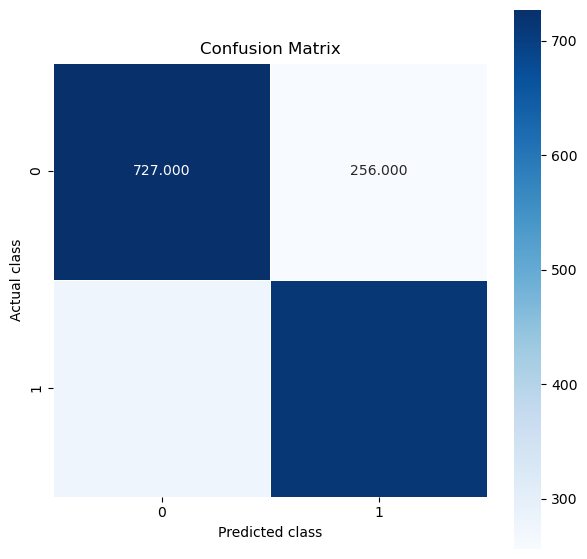

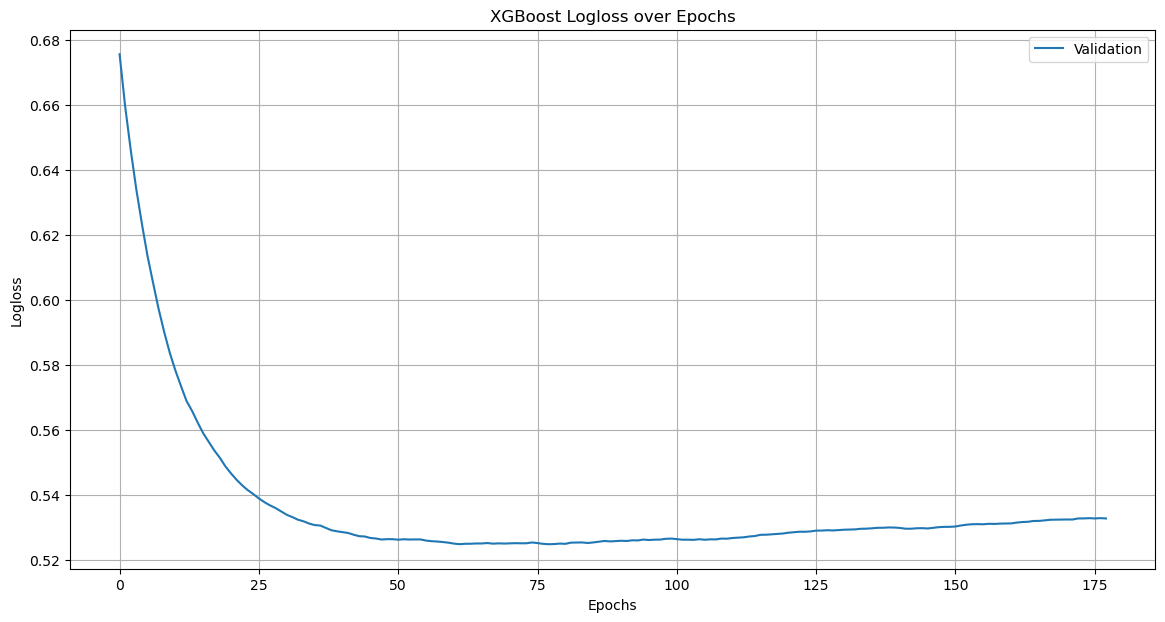

In [2]:
# 샘플링 수 증가 n_iter=200
# 교차 검증 갯수 증가 (3겹 -> 5겹)
# Fitting 5 folds for each of 200 candidates, totalling 1000 fits -> 5겹을 사용 하여 200개의 후보군을 가지고 1000개의 모델 학습
# 성능 향상 시간 20으로 증가 -> 조기 종료 기준 20 -> 향샹도가 낮을 경우 종류
# 조기 종료 기준 17로 조정

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, randint

# 데이터 불러오기
df = pd.read_csv('C:/Users/NT551/Desktop/데이터 추출(연습)/high_diamond_ranked_10min.csv')

# 타겟 변수와 피처 변수 설정
y = df['blueWins']   # 목표 값
X = df.drop(columns=['blueWins', 'gameId']) # 예측에 사용할 나머지 데이터 (blueWins, gameId 제외)

# 데이터 전처리: 피처 스케일링
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 분포 설정
param_dist = {
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 10),
    'n_estimators': randint(300, 500),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_lambda': uniform(1, 10),
    'reg_alpha': uniform(0, 5)
}

# XGBoost 모델 초기화
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# F1 Score 및 ROC AUC 지표 설정
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Randomized Search 초기화
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=200,   # 샘플링할 수의 수  원래는 200
    cv=5,         # 5겹 교차 검증
    scoring=scoring,
    verbose=2,    # 학습 과정 자세히 출력
    n_jobs=-1,    # 병렬 처리
    random_state=42,
    refit='f1'    # F1 Score를 기준으로 최적 모델을 재학습
)

# 모델 학습
start_time = time.time()
random_search.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_valid, y_valid)], verbose=True)   # early_stopping_rounds=10 성능이 지정한 구간동안 향상되지 않으면 멈춘다 원래는 20
end_time = time.time()
elapsed_time = end_time - start_time

# 최적 하이퍼파라미터 출력
print(f'Best parameters: {random_search.best_params_}')

# 최적 모델로 예측
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# 최적 모델 평가
accuracy_best = accuracy_score(y_valid, y_pred_best)
f1_best = f1_score(y_valid, y_pred_best)
roc_auc_best = roc_auc_score(y_valid, y_pred_proba)

print(f'Best model accuracy: {accuracy_best:.4f}')
print(f'Best model F1 Score: {f1_best:.4f}')
print(f'Best model ROC AUC: {roc_auc_best:.4f}')

# 경과 시간 출력
print(f'Total time taken: {elapsed_time:.2f} seconds')

# 혼동 행렬 시각화
conf_mat = confusion_matrix(y_valid, y_pred_best)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel("Actual class")
plt.xlabel("Predicted class")
plt.title("Confusion Matrix")
plt.show()

# 학습 과정 시각화
evals_result = best_model.evals_result()  # XGBClassifier의 evals_result 호출

epochs = len(evals_result['validation_0']['logloss'])
x_axis = range(0, epochs)

# 로그 손실 시각화
plt.figure(figsize=(14, 7))
plt.plot(x_axis, evals_result['validation_0']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss over Epochs')
plt.legend()
plt.grid(True)
plt.show()
